In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/home/cholt/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [5]:
os.getpid()

13652

In [6]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [7]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, r_fp = ssn_PS(params, contrasts)
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
    spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    rates_loss = losses.loss_rates_contrasts(r_fp)
    param_loss = losses.loss_params(params)
    
    if spect_loss/rates_loss < 1:
        print('rates loss is greater than spect loss')
#     print(spect_loss/rates_loss) 
    
    return spect_loss + rates_loss + param_loss
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))




# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

run time: 13.496162176132202


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

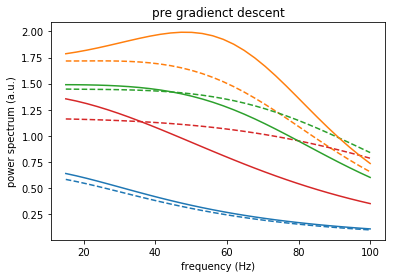

In [8]:
# params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5, 1.3, 2.4, 1.0, 1.0, 1.0, 0.6])
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

# Run Gradient Descent

In [9]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 1000
eta = .005 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


KeyboardInterrupt: 

In [ ]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [ ]:
print(losses.loss_rates_contrasts(r_fp))
print(losses.loss_spect_contrasts(fs, np.real(spect)))

In [ ]:
plt.plot(loss_t[:])

## If first loss didn't quite converge, run it again!

In [ ]:
#dloss = grad(loss)
# dloss = value_and_grad(loss)

gd_iters = 1000
eta = .005 #learning rate

# params = params_init
# loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

In [ ]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, [ax, ax2] = plt.subplots(1,2)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

ax2.plot(loss_t[:])
ax2.set_title('Loss')
ax2.set_xlabel('G.D. Step')

## Save data 

In [ ]:
import scipy.io as sio

data = {
    'params_final':params,
    'params_init':params_init,
    'spect_final':spect,
    'rfp_final':r_fp,
    'loss_t':loss_t,
    'ideal_fname':'standJ19-09-20-BestSpect.mat'
}


sio.savemat("ExpandParams_2019-09-26.mat", data)